In [178]:
import math
import numpy as np
import cmath 

import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (15, 10),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params)

In [179]:
def getSpice(y):
    print( '.param g11= {0.real:6.4E}' .format(y[0,0]) )
    print( '.param g12= {0.real:6.4E}' .format(y[0,1]) )
    print( '.param g21= {0.real:6.4E}' .format(y[1,0]) )
    print( '.param g22= {0.real:6.4E}' .format(y[1,1]) )
    print( '.param c11= {0:6.4E}' .format(y[0,0].imag/(wo)) )
    print( '.param c12= {0:6.4E}' .format((y[0,1].imag)/(wo)) )
    print( '.param c21= {0:6.4E}' .format((y[1,0].imag)/(wo)) )
    print( '.param c22= {0:6.4E}' .format(y[1,1].imag/(wo)) )

def getComp(y):
    print( '.param gg= {0.real:6.4}' .format(y) )
    print( '.param cg= {0:6.4E}' .format((y.imag)/(wo)) )
    
    


In [180]:
def yin(y,ys):
    return y[0,0] - (y[0,1]*y[1,0])/(y[1,1]+ys)

def yout(y,ys):
    return y[1,1] - (y[0,1]*y[1,0])/(y[0,0]+ys)

def ydw(y,wo,w):
    b = y.imag
    yw = y.real +1j*b*(w/wo)
    #if b < 0  : yw = y.real +1j*b*(wo/w)    
    #if b == 0 : yw = y.real
    return yw

def gbw(g,bc,bl,wo,w):
    y = (g + 1j * (bc*(w/wo) -bl*(wo/w)))
    return y
    
def ycdw(y,wo,w):
    y11w = ydw(y[0,0],wo,w)
    y12w = ydw(y[0,1],wo,w)
    y21w = ydw(y[1,0],wo,w)
    y22w = ydw(y[1,1],wo,w)
    yt = np.matrix([[y11w, y12w],[ y21w, y22w]])
    return yt

def RLC(y,Qo,Qc,wo):    
    g  = y.real
    rext = (1/y.real)/2
    bl   = (1/Qc-1/Qo)*rext
    bc   =  bl
    if y.imag > 0 : bc = bc - abs(y.imag)
    if y.imag < 0 : bl = bl - abs(y.imag)
    gp  = 1/(bl*Qo)
    return (g,bc,bl,gp)


In [182]:
Qo = 100

wo = 2*math.pi*10.7e6

Qa = 10
wa = 2*math.pi*10.7e6
Qb = 10
wb = 2*math.pi*10.7e6

# MMBT918 Ic = 4mA, VCE=10V, fo=10.7MHz
y11 =   1.30e-3  + 0.80e-3*1j
y12 = - 0.01e-3  - 0.08e-3*1j
y21 =     95e-3  -   19e-3*1j 
y22 =   0.08e-3  + 0.20e-3*1j

# neutralizado
y11= 1.30E-03+1j*(1.28E-03)
y12= -1.00E-05+1j*(0.00E+00)
y21= 9.50E-02-1j*(1.89E-02)
y22= 8.00E-05+1j*(2.13E-04)

fo = 100e6
wo = 2*np.pi*fo

y11 =   5.00e-3 + 1.50e-3*1j
y12 = - 0.012e-3 - 0.02e-3*1j
y21 =   5.50e-3 - 0.38e-3*1j 
y22 =   0.04e-3 + 0.70e-3*1j


ytr = np.matrix([[y11, y12],[ y21, y22]])

getSpice(ytr)


.param g11= 5.0000E-03
.param g12= -1.2000E-05
.param g21= 5.5000E-03
.param g22= 4.0000E-05
.param c11= 2.3873E-12
.param c12= -3.1831E-14
.param c21= -6.0479E-13
.param c22= 1.1141E-12


In [183]:
yga  = ytr[0,0].real - 1j* ytr[0,0].imag
# yg evaluado en wb
ygb  = ydw(yga,wa,wb)
for n in range(5):
    # el transistor evaluado en wb
    ytrb = ycdw(ytr,wo,wb)
    # salida del transistor en wb
    yob  = yout(ytrb,ygb)
    # Calculo los componentes
    (gb,bcb,blb,gpb) = RLC(yob,Qo,Qb,wb)
    # la carga que sintonia la salida
    ylb = gb + gpb + 1j *(bcb - blb)
    # la admitancia de la salida evaluada en wa
    yla  = gbw(gb+gpb,bcb,blb,wb,wa)
    # el transistor evaluado en wa
    ytra = ycdw(ytr,wo,wa)
    # entrada del transistor en wa
    yia  = yin(ytra,yla)
    # Calculo los componentes
    (ga,bca,bla,gpa) = RLC(yia,Qo,Qa,wa)
    # la carga que sintonia la salida
    yga = ga + gpa + 1j *(bca - bla)
    # yg evaluado en wb
    ygb  = gbw(ga+gpa,bca,bla,wa,wb)  
    print(1/yia.real, yia.imag/wa)
    print(1/yob.real, yob.imag/wb)
    
print(yia)
print(yob)
    
    
print(1/yia.real, yia.imag/wa)
print(1/yob.real, yob.imag/wb)
    
print( '.param rg= {0:6.4E}'     .format(1/ga) )
print( '.param cg= {0:6.4E}'     .format(bca/wa) )
print( '.param lg= {0:6.4E}'     .format(1/(bla*wa)) )    
print( '.param rgp= {0:6.4E}'     .format(1/gpa) )


print( '.param rl= {0:6.4E}'     .format(1/gb) )
print( '.param cl= {0:6.4E}'     .format(bcb/wb) )
print( '.param ll= {0:6.4E}'     .format(1/(blb*wb)) )    
print( '.param rlp= {0:6.4E}'     .format(1/gpb) )



yli  = gbw(gb+gpb,bcb,blb,wb,wo)
#ytri = ycdw(ytr,wo,wo)
ygi  = gbw(ga+gpa,bca,bla,wa,wo)
yia  = yin(ytr,yli) + ygi
    


print( '|yia|= {0:6.4E}, <yio= {1:6.1F}' .format(abs(1/yia), cmath.phase(1/yia)*180./np.pi) )

176.020513308 4.33112006154e-12
21577.8806606 1.14350526883e-12
175.756373909 4.24979250897e-12
21967.2824003 1.12903374285e-12
175.755051193 4.24953220207e-12
21969.3696163 1.12898244937e-12
175.755044523 4.24953141882e-12
21969.3805042 1.12898226048e-12
175.755044486 4.24953140959e-12
21969.3805606 1.12898225977e-12
(0.00568973711635+0.000285696348472j)
(4.55178969312e-05+7.59015707894e-05j)
175.755044486 4.24953140959e-12
21969.3805606 1.12898225977e-12
.param rg= 1.7576E+02
.param cg= 1.1764E-07
.param lg= 1.8807E-09
.param rgp= 7.9090E+02
.param rl= 2.1969E+04
.param cl= 1.4705E-05
.param ll= 1.5045E-11
.param rlp= 9.8862E+04
|yia|= 1.3686E-02, <yio=  -90.0


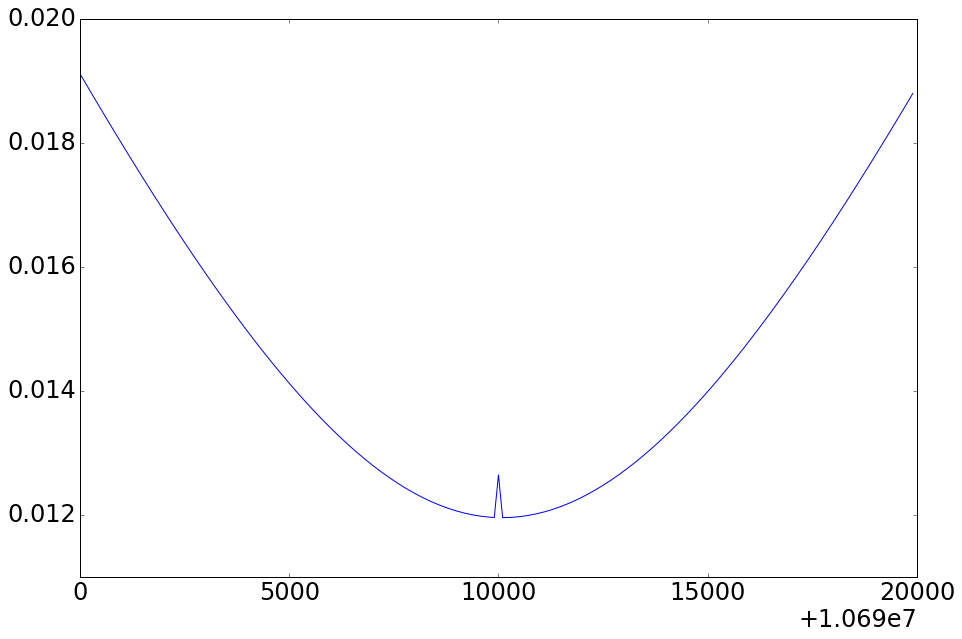

In [184]:
f  = np.arange(10.69e6,10.71e6,1e2)
w  = 2*math.pi*f
ym = list()
for wi in w:
    yli  = gbw(gb+gpb,bcb,blb,wb,wi)
    ytri = ycdw(ytr,wo,wi)
    ygi  = gbw(ga+gpa,bca,bla,wa,wi)
    yia  = yin(ytri,yli) + ygi
    
    
    ym.append(yia)
plt.plot(f, [abs(y) for y in ym])
    
plt.show()

In [185]:
ygb  = ydw(yg,wo,wb)
ytrb = ycdw(ytr,wo,wb)
yob  = yout(ytrb,ygb)
(gb,bcb,blb,gpb) = RLC(yob,Qo,Qc,wb)

print( '.param rl= {0:6.4E}'     .format(1/gb) )
print( '.param cl= {0:6.4E}'     .format(bcb/wb) )
print( '.param ll= {0:6.4E}'     .format(1/(blb*wb)) )    
print( '.param rp= {0:6.4E}'     .format(1/gpb) )


ylb = gb + gpb + 1j *(bcb - blb)
yla  = ydw(ylb,wb,wa)
ytra = ycdw(ytr,wo,wa)
yia  = yin(ytra,yla)


print( '|yia|= {0:6.4E}, <yio= {1:6.1F}' .format(abs(yia), cmath.phase(yia)*180./np.pi) )

.param rl= 1.9581E+04
.param cl= 1.3106E-05
.param ll= 1.6881E-11
.param rp= 8.8114E+04
|yia|= 5.6505E-03, <yio=    2.8
